## Introduction to the automated analysis of EEG quality


This notebook will introduce you to the challenge by going through the data and working towards a first very simple model.


## Loading the data


In [1]:
## First let's load the training data
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import pandas as pd

ROOT_PATH = Path(
    "/kaggle/input/eeg-signal-quality-analysis-by-beacon-biosignals/train/"
)
ROOT_PATH = "./train/"
training_data = [
    (np.load(ROOT_PATH + f"data_{i}.npy"), np.load(ROOT_PATH + f"target_{i}.npy"))
    for i in range(4)
]

We expect to have five channels and one label per channel for each two seconds of data.
Let's have a look at the data duration and shape


In [2]:
# Let's have a look at the data duration
for i, (data, target) in enumerate(training_data):
    print()
    print(f"Recording {i}")
    print("Data shape", data.shape, target.shape)
    print("Data duration:", data.shape[1] / 250)
    print("Labels duration", target.shape[1] * 2)


Recording 0
Data shape (5, 7712740) (5, 15425)
Data duration: 30850.96
Labels duration 30850

Recording 1
Data shape (5, 5232364) (5, 10464)
Data duration: 20929.456
Labels duration 20928

Recording 2
Data shape (5, 6421756) (5, 12843)
Data duration: 25687.024
Labels duration 25686

Recording 3
Data shape (5, 6809761) (5, 13619)
Data duration: 27239.044
Labels duration 27238


## Data Visualization


In [3]:
## We improve a bit the plotting code to plot span of data and corresponding label
def plot_predictions_and_signal(
    target,
    data,
    start_time: float,
    stop_time: float,
    data_sampling_rate: int = 250,
    target_duration: int = 2,
    channel_to_plot: int = 0,
):
    # Calculate the start and stop indices for the signal
    start_idx_signal = int(start_time * data_sampling_rate)
    stop_idx_signal = int(stop_time * data_sampling_rate)

    # Calculate the start and stop indices for the labels
    start_idx_label = int(start_time / target_duration)
    stop_idx_label = int(stop_time / target_duration)

    # Slice the data and prediction probabilities
    sliced_signal = data[channel_to_plot, start_idx_signal:stop_idx_signal]
    sliced_prediction_prob = target[channel_to_plot, start_idx_label:stop_idx_label]

    fig, ax = plt.subplots(1, 1, figsize=(10, 3))

    # Plot the sliced EEG signal
    ax.plot(np.arange(len(sliced_signal)) / data_sampling_rate, sliced_signal)
    ax.set_title("EEG signal")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")

    ax_tw = ax.twinx()
    ax_tw.scatter(
        np.arange(len(sliced_prediction_prob)) * target_duration,
        sliced_prediction_prob,
        color="r",
        marker="o",
        alpha=0.7,
    )
    ax_tw.set_xlabel("Time (s)")
    ax_tw.set_ylabel("Probs")
    ax_tw.set_ylim(-0.1, 1.1)
    plt.tight_layout()

    plt.show()

0.5086964831804281


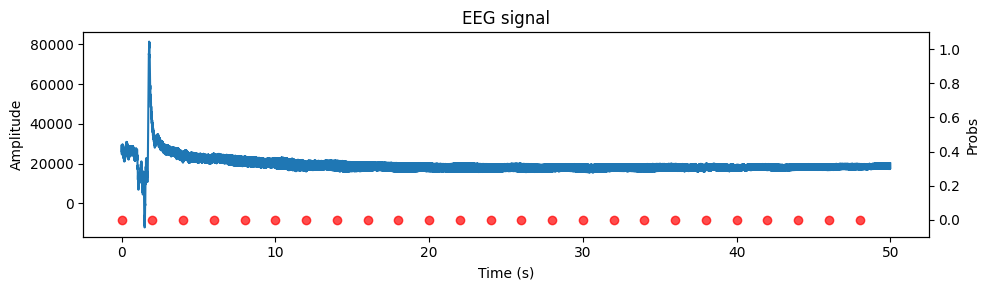

In [4]:
# We first plot the data and target from the first recording
# We see that there is a big DC component
target = np.load(ROOT_PATH + "/target_1.npy")
data = np.load(ROOT_PATH + "/data_1.npy")

print(np.mean(target))

plot_predictions_and_signal(
    target,
    data,
    start_time=300,
    stop_time=350,
    channel_to_plot=1,
)

To remove the DC component and high frequency component we apply a band-pass filter


# Data Filtering


In [5]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype="band")


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

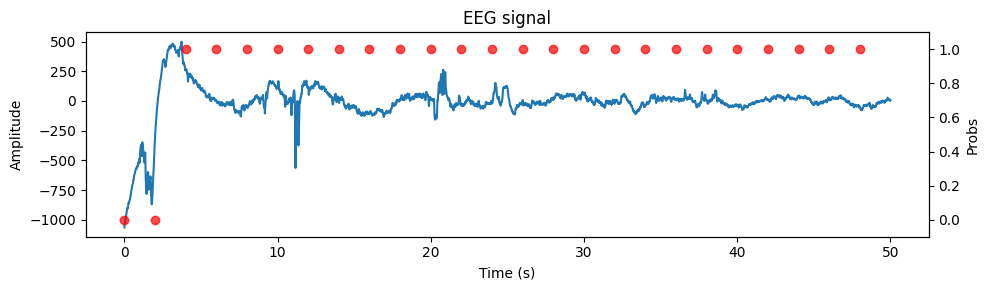

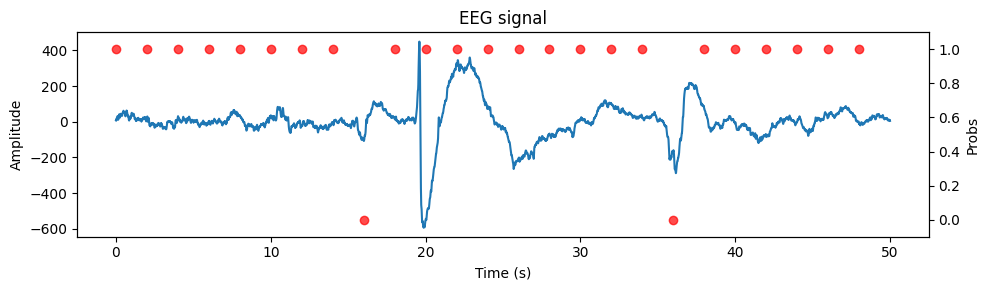

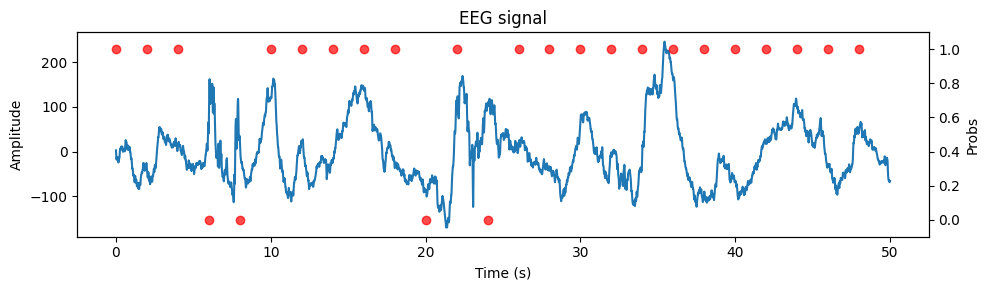

In [6]:
filtered_data = butter_bandpass_filter(data, 0.1, 18, 250, 4)
# We plot three spans and associated labels from the recording

plot_predictions_and_signal(
    target,
    filtered_data,
    start_time=300,
    stop_time=350,
    channel_to_plot=2,
)
plot_predictions_and_signal(
    target,
    filtered_data,
    start_time=350,
    stop_time=400,
    channel_to_plot=2,
)
plot_predictions_and_signal(
    target,
    filtered_data,
    start_time=400,
    stop_time=450,
    channel_to_plot=2,
)

We see that some of the high amplitude is classified as bad quality, we could use that to build a first simple model


## Reshape the data by windowing


In [7]:
# First we need to get the point that maps to a label


def reshape_array_into_windows(x, sample_rate, window_duration_in_seconds):
    """
    Reshape the data into an array of shape (C, T, window) where 'window' contains
    the points corresponding to 'window_duration' seconds of data.

    Parameters:
    x (numpy array): The input data array.
    sample_rate (int): The number of samples per second.
    window_duration_in_seconds (float): The duration of each window in seconds.

    Returns:
    reshaped_x (numpy array): The reshaped array with shape (C, T, window).
    """
    # Calculate the number of samples in one window
    window_size = int(window_duration_in_seconds * sample_rate)

    # Ensure the total length of x is a multiple of window_size
    total_samples = x.shape[-1]
    if total_samples % window_size != 0:
        # Truncate or pad x to make it divisible by window_size
        x = x[..., : total_samples - (total_samples % window_size)]
    # Reshape x into (C, T, window)
    reshaped_x = x.reshape(x.shape[0], -1, window_size)

    return reshaped_x

In [8]:
reshaped_array = reshape_array_into_windows(filtered_data, 250, 2)
assert np.array_equal(reshaped_array[0, 0], filtered_data[0, :500])  # Quick unit
print("Initial Data Shape : ", data.shape)
print("Reshaped Array Shape : ", reshaped_array.shape)

Initial Data Shape :  (5, 5232364)
Reshaped Array Shape :  (5, 10464, 500)


`reshaped_array` is now a 3D array with `(channel_of_EEG, number of windows, window_size)`
We will calculate the mean and standard deviation of the EEG for each channel and window and then reshape have a unidimension format `(number of windows)` because we want a dataset in the format `(window_i_j, features)` where `i` is the channel and `j` is the window


## Gather Data from all the files


In [9]:
all_data = []
all_targets = []
all_channel_indices = []

# Iterate over the data
for data, target in training_data:
    # Shapes: data, target -> (5, 7712740), (5, 15425)
    filtered_data = butter_bandpass_filter(data, 0.1, 18, 250, 4)  # Shape: (5, 7712740)
    windowed_data = reshape_array_into_windows(
        filtered_data, 250, 2
    )  # Shape: (5, 15425, 500)
    targets_flatten = target[..., : windowed_data.shape[1]].reshape(
        -1
    )  # Shape: (77125,)

    # Reshape data and track channel indices
    flattened_data = windowed_data.reshape(
        (-1, windowed_data.shape[-1])
    )  # Shape: (77125, 500)
    num_samples_per_channel = windowed_data.shape[1]
    channel_indices = np.repeat(
        np.arange(data.shape[0]), num_samples_per_channel
    )  # Shape: (77125,)

    # Append to the lists
    all_data.append(flattened_data)
    all_targets.append(targets_flatten)
    all_channel_indices.append(channel_indices)

# Concatenate all data, targets, and channel indices
all_data = np.concatenate(all_data)
all_targets = np.concatenate(all_targets)
all_channel_indices = np.concatenate(all_channel_indices)

assert all_data.shape[0] == all_targets.shape[0] == all_channel_indices.shape[0]

`all_data` contains all the training data with shape `(number of windows, window_size)` and `all_labels` contains the labels with shape `(number of windows)`. All EEG were concatenated.
\
\
Note : One butterworth filter was applied to all the EEG data


# Feature creation


In [10]:
# This will be our dataframe where we will progressively add features calculated from all_data
df = pd.DataFrame({"target": all_targets, "channel": all_channel_indices})

### Amplitude


In [11]:
# We can now compute the mean, max and stdev over each 2 seconds segment to try to build features
amplitude = (np.max(all_data, -1) - np.min(all_data, -1)).reshape(-1)
df["log_amplitude"] = np.log(amplitude + 1)

<Axes: xlabel='log_amplitude'>

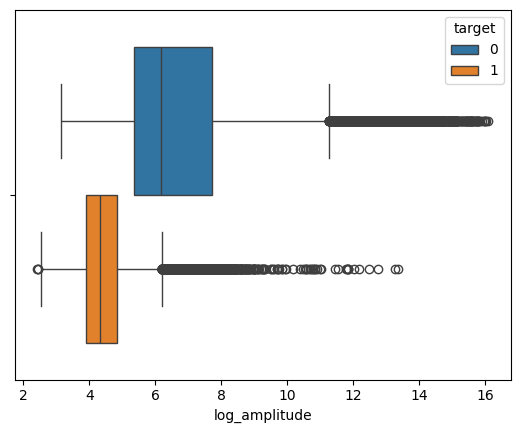

In [12]:
sns.boxplot(df, x="log_amplitude", hue="target")

### Mean


In [13]:
mean = np.mean(all_data, -1).reshape(-1)
rescaled_mean = mean + abs(mean.min())
df["mean"] = mean

<Axes: xlabel='mean'>

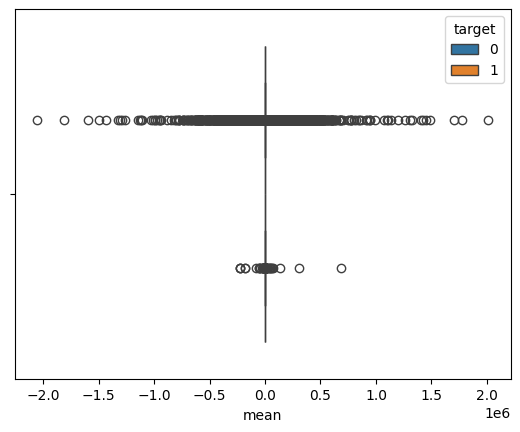

In [14]:
sns.boxplot(df, x="mean", hue="target")

### Min and Max


In [15]:
min = np.min(all_data, -1).reshape(-1)
max = np.max(all_data, -1).reshape(-1)
df["min"] = min
df["max"] = max

<Axes: xlabel='max'>

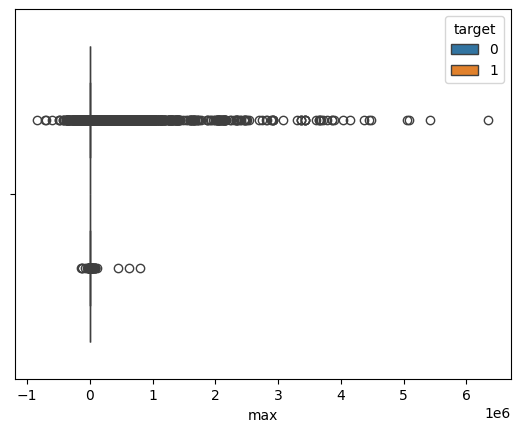

In [16]:
sns.boxplot(df, x="max", hue="target")

### Standard Deviation


In [17]:
std = (np.std(all_data, axis=-1)).reshape(-1)
df["log_std"] = np.log(std + 1)

<Axes: xlabel='log_std'>

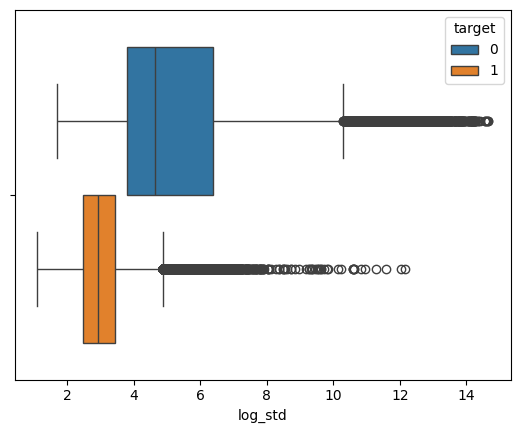

In [18]:
sns.boxplot(df, x="log_std", hue="target")

### Skew


In [19]:
from scipy.stats import skew

skewness = (skew(all_data, axis=-1)).reshape(-1)
df["skewness"] = skewness

<Axes: xlabel='skewness'>

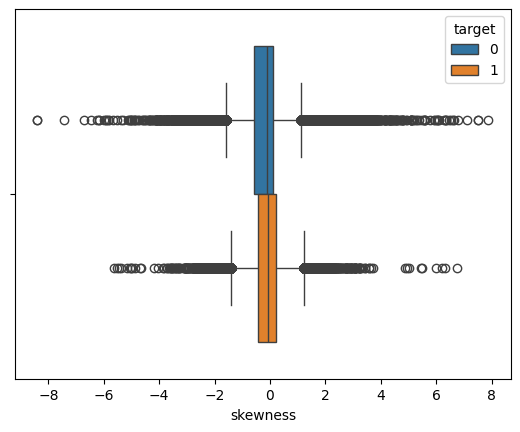

In [20]:
sns.boxplot(df, x="skewness", hue="target")

### Kurtosis


In [21]:
from scipy.stats import kurtosis

kurt = (kurtosis(all_data, axis=-1)).reshape(-1)
df["log_kurtosis"] = np.log(kurt + np.abs(np.min(kurt)) + 1)

<Axes: xlabel='log_kurtosis'>

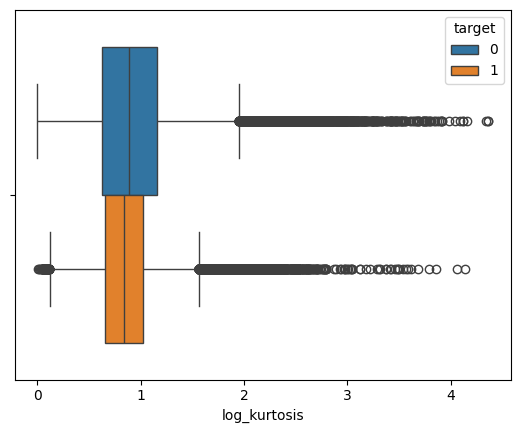

In [22]:
sns.boxplot(df, x="log_kurtosis", hue="target")

### MMD (Min Max Distance)

It allows to calculate the pythagoeran distance between the min and max of the EEG signal.


In [23]:
idx_diff_between_max_and_min = (
    np.argmax(all_data, axis=-1) - np.argmin(all_data, axis=-1)
).reshape(-1)
amplitude = (np.max(all_data, -1) - np.min(all_data, -1)).reshape(-1)
MMD = idx_diff_between_max_and_min**2 + amplitude**2
df["log_MMD"] = np.log(MMD + 1)

<Axes: xlabel='log_MMD'>

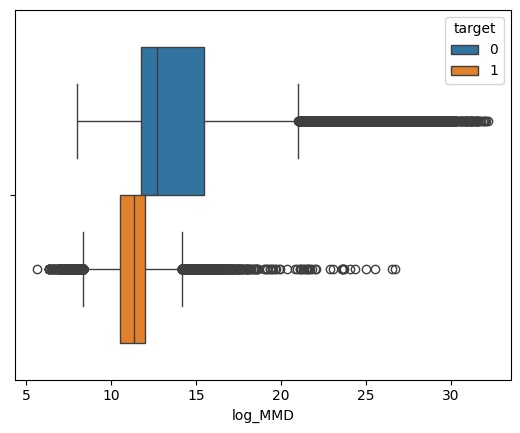

In [24]:
sns.boxplot(df, x="log_MMD", hue="target")

### Energy of the signal


In [25]:
# Calculate energy of signal
energy = (np.sum(all_data**2, axis=-1)).reshape(-1)
df["log_energy"] = np.log(energy + 1)

<Axes: xlabel='log_energy'>

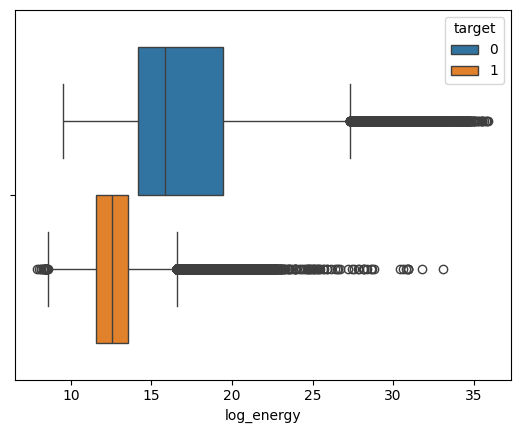

In [26]:
sns.boxplot(df, x="log_energy", hue="target")

### Esis


### Decomposition of the signal (DWT = Discrete Wavelet Transform)


### Decomposition of the signal into trend, seasonality and residuals


In [27]:
# Add linear trend of the window
from scipy.stats import linregress

linear_trend = np.apply_along_axis(
    lambda x: linregress(np.arange(len(x)), x).slope, -1, all_data
).reshape(-1)
df["linear_trend"] = linear_trend

<Axes: xlabel='linear_trend'>

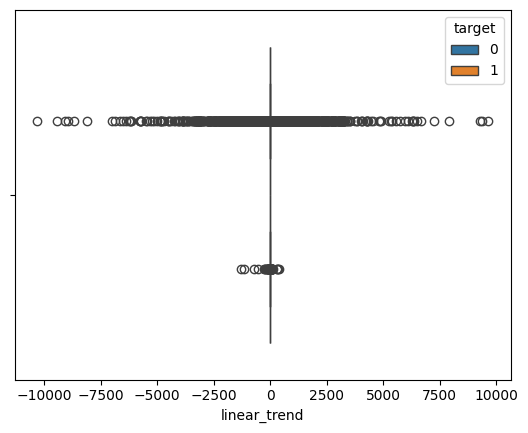

In [28]:
sns.boxplot(df, x="linear_trend", hue="target")

### Autocorrelation of the signal


In [29]:
# Add autocorrelation of each window

from scipy.signal import correlate

### Number of zero crossings


In [30]:
# Calculate the number of zero crossings for each window
def zero_crossings(x):
    return np.sum(np.diff(np.sign(x)) != 0)


zero_cross = np.apply_along_axis(zero_crossings, -1, all_data).reshape(-1)
df["zero_crossing"] = zero_cross

<Axes: xlabel='zero_crossing'>

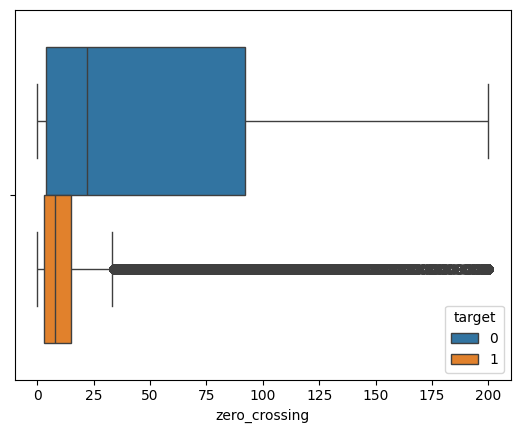

In [31]:
sns.boxplot(df, x="zero_crossing", hue="target")

### Number of peaks


In [32]:
# Count the number of peaks in each window
from scipy.signal import find_peaks


def count_peaks(x):
    return len(find_peaks(x)[0])


peaks = np.apply_along_axis(count_peaks, -1, all_data).reshape(-1)
df["peaks"] = peaks

<Axes: xlabel='peaks'>

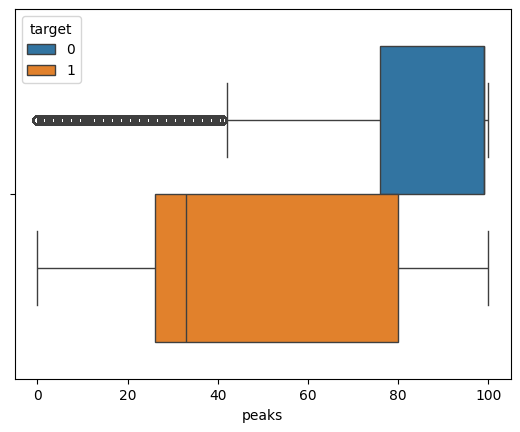

In [33]:
sns.boxplot(df, x="peaks", hue="target")

# EDA & Data Quality Check


In [34]:
df.isna().sum()

target           0
channel          0
log_amplitude    0
mean             0
min              0
max              0
log_std          0
skewness         0
log_kurtosis     0
log_MMD          0
log_energy       0
linear_trend     0
zero_crossing    0
peaks            0
dtype: int64

In [35]:
df.head()

,target,channel,log_amplitude,mean,min,max,log_std,skewness,log_kurtosis,log_MMD,log_energy,linear_trend,zero_crossing,peaks
0,0,0,10.261250,1245.339194,-7130.450154,21471.069232,8.959498,0.764981,0.811391,20.522720,24.158645,-50.698929,1,3
1,0,0,8.923717,-4967.769465,-7984.635913,-477.688412,7.797374,0.305130,0.438344,17.850264,23.451093,16.395815,0,5
2,0,0,8.309466,2367.076976,-465.337390,3595.805041,7.082385,-0.796025,0.822718,16.631632,21.978695,7.847963,1,13
3,0,0,7.691416,2762.803937,1439.098032,3627.571220,6.546664,-0.313611,0.480159,15.425152,22.124127,-4.742306,0,17
4,0,0,7.771744,9.834008,-945.135745,1426.469571,6.481641,0.348448,0.631810,15.585964,19.175053,-4.472018,1,21


# Feature selection


In [36]:
list(df.columns)

['target',
 'channel',
 'log_amplitude',
 'mean',
 'min',
 'max',
 'log_std',
 'skewness',
 'log_kurtosis',
 'log_MMD',
 'log_energy',
 'linear_trend',
 'zero_crossing',
 'peaks']

# Train test split


We need to split our data into train and test. However. we need to be careful on how we split because :

- If window `i` is in the training set and window `i+1` is in the test set, we will have data leakage because we can expect that the quality of the EEG is correlated between two consecutive windows.
- Our data is not balanced, we need to make sure that the train and test set have the same proportion of good and bad quality EEG.

We will :

- Shuffle the data to remove the data leakage
- Stratify the data to keep the same proportion of good and bad quality EEG in the train and test set


In [37]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

df_shuffled = df.sample(frac=1, random_state=42)
X = df_shuffled.drop("target", axis=1)
y = df_shuffled["target"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y.values
)

# Baseline models


The goal is to build a simple model that can be used as a baseline. We will use a logistic regression and a random forest.


In [38]:
from pycaret.classification import ClassificationExperiment

In [39]:
s = ClassificationExperiment()
s.setup(df_shuffled, target="target", session_id=123)

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(261755, 14)"
4,Transformed data shape,"(261755, 14)"
5,Transformed train set shape,"(183228, 14)"
6,Transformed test set shape,"(78527, 14)"
7,Numeric features,13
8,Preprocess,True
9,Imputation type,simple


In [40]:
best = s.compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:44:11
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [31]:
s.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

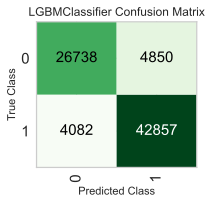

In [32]:
s.plot_model(best, plot="confusion_matrix", plot_kwargs={"size": (300, 300)})

In [92]:
from lightgbm import LGBMClassifier

model = LGBMClassifier()
model.fit(X_train, y_train)
prediction = model.predict(X_test)

[LightGBM] [Info] Number of positive: 125169, number of negative: 84235
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 209404, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.597739 -> initscore=0.396054
[LightGBM] [Info] Start training from score 0.396054


We can now evaluate the cohen kappa


In [93]:
from sklearn.metrics import cohen_kappa_score, f1_score

print(cohen_kappa_score(prediction, y_test))
print(f1_score(prediction, y_test))

0.7653964699234047
0.9064158378086371


# Hyperparameter tuning with Cross-Validation and Optuna


Key points for cross validation:

- StratifyKFold


## Running the model on the test data and submitting to the leaderboard


In [35]:
ROOT_TEST_PATH = Path(
    "/kaggle/input/eeg-signal-quality-analysis-by-beacon-biosignals/test/"
)
ROOT_TEST_PATH = "test/"
test_data = {i: np.load(ROOT_TEST_PATH + f"data_{i}.npy") for i in [4, 5]}
# We process each record independantly


def compute_features_on_record(data):
    """
    We compute each of the feature for each window and each channel
    Each value of the output dict has shape (Channels,T)
    """
    filtered_data = butter_bandpass_filter(data, 0.1, 18, 250, 4)
    reshaped_data = reshape_array_into_windows(filtered_data, 250, 2)
    amplitude = np.max(reshaped_data, -1) - np.min(reshaped_data, -1)
    log_amplitude = np.log(amplitude + 1)
    std = np.std(reshaped_data, axis=-1)
    log_std = np.log(std + 1)
    skewness = skew(reshaped_data, axis=-1)
    kurt = kurtosis(reshaped_data, axis=-1)
    log_kurtosis = np.log(kurt + np.abs(np.min(kurt)) + 1)
    return {
        "amplitude": amplitude,
        "log_amplitude": log_amplitude,
        "std": std,
        "log_std": log_std,
        "skewness": skewness,
        "kurtosis": kurt,
        "log_kurtosis": log_kurtosis,
    }


def compute_predictions_on_record(data, model, features_name_for_model):
    predictions = []
    features = compute_features_on_record(data)
    features = np.array([features[k] for k in features_name_for_model])
    features = features.swapaxes(0, 1).swapaxes(1, 2)
    for channel in range(features.shape[0]):
        predictions.append(model.predict(features[channel]))
    return np.array(predictions)


def format_array_to_target_format(array, record_number):
    assert isinstance(record_number, int)
    assert isinstance(array, np.ndarray)
    assert len(array.shape) == 2
    assert array.shape[0] == 5
    assert set(np.unique(array)) == {0, 1}
    formatted_target = []
    for i in range(array.shape[0]):
        channel_encoding = (i + 1) * 100000
        record_number_encoding = record_number * 1000000
        for j in range(array.shape[1]):
            formatted_target.append(
                {
                    "identifier": record_number_encoding + channel_encoding + j,
                    "target": array[i, j],
                }
            )
    return formatted_target

We the functions defined above, we can now run the model and submit the predictions


In [36]:
results = []
features_name_for_model = col_to_keep
for record_number, data in test_data.items():
    preds = compute_predictions_on_record(data, neigh, col_to_keep)
    formatted_preds = format_array_to_target_format(preds, record_number)
    results.extend(formatted_preds)
df = pd.DataFrame(results)
df.to_csv("submission.csv", index=False)